## Predicting Car Fuel Energy

### Data Preparation

In [2]:
import numpy as np
import pandas as pd

In [3]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

In [4]:
!wget $data -O car_fuel_efficiency.csv

--2025-10-10 17:24:03--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  2.02MB/s    in 0.4s    

2025-10-10 17:24:04 (2.02 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [5]:
cols = [
    "engine_displacement",
    "horsepower",
    "vehicle_weight",
    "model_year",
    "fuel_efficiency_mpg",
]

df_full = pd.read_csv("car_fuel_efficiency.csv")
df = df_full[cols].copy()
len(df), df.head()

(9704,
    engine_displacement  horsepower  vehicle_weight  model_year  \
 0                  170       159.0     3413.433759        2003   
 1                  130        97.0     3149.664934        2007   
 2                  170        78.0     3079.038997        2018   
 3                  220         NaN     2542.392402        2009   
 4                  210       140.0     3460.870990        2009   
 
    fuel_efficiency_mpg  
 0            13.231729  
 1            13.688217  
 2            14.246341  
 3            16.912736  
 4            12.488369  )

### Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt

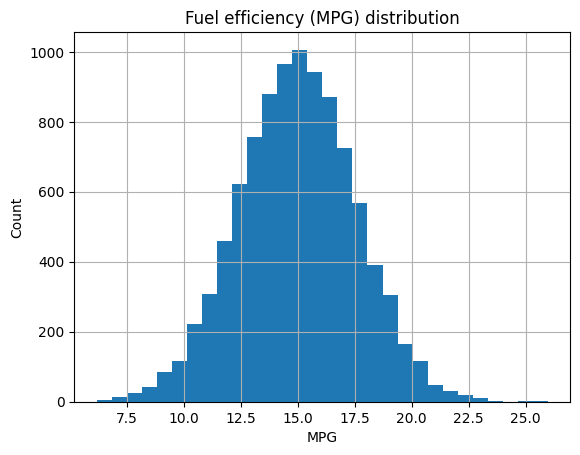

In [7]:
target = "fuel_efficiency_mpg"
ax = df[target].hist(bins=30)
ax.set_title("Fuel efficiency (MPG) distribution")
ax.set_xlabel("MPG")
ax.set_ylabel("Count")
plt.show()

In [8]:
print("Describe MPG:")
display(df[target].describe())

Describe MPG:


count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64

In [9]:
print("\nMissing values per column:")
na_counts = df.isna().sum()
display(na_counts)


Missing values per column:


engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [10]:
#names of columns with missing values
col_with_na = na_counts[na_counts > 0].index.tolist()
col_with_na

['horsepower']

### Median Horsepower

In [11]:
hp_median = df["horsepower"].median()
hp_median

np.float64(149.0)

### Validation

In [12]:
def split_train_val_test(df, seed=42):
    n = len(df)
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    n_train = int(0.6 * n)
    n_val   = int(0.2 * n)
    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]
    return df.iloc[train_idx].copy(), df.iloc[val_idx].copy(), df.iloc[test_idx].copy()

In [13]:
df_train, df_val, df_test = split_train_val_test(df, seed=42)

In [14]:
len(df_train), len(df_val), len(df_test)

(5822, 1940, 1942)

### Features and Target

In [15]:
features = ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]
target = "fuel_efficiency_mpg"

In [16]:
def get_mean_stats(df, cols):
    return {c: df[c].mean() for c in cols}

In [17]:
def prepare_X(df, fill_strategy="zero", stats=None):
    X = df[features].copy()
    if fill_strategy == "zero":
        X = X.fillna(0)
    elif fill_strategy == "mean":
        assert stats is not None, "Mean stats required for fill_strategy='mean'"
        for c in features:
            X[c] = X[c].fillna(stats[c])
    else:
        raise ValueError("fill_strategy must be 'zero' or 'mean'")
    X = X.values
    # add bias column
    X = np.column_stack([np.ones(X.shape[0]), X])
    return X

In [18]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [19]:
def train_linear_regression(X, y, r=0.0):
    XTX = X.T.dot(X)
    # L2 regularization, don't regularize bias at [0,0]
    if r > 0:
        reg = r * np.eye(XTX.shape[0])
        reg[0, 0] = 0.0
        XTX = XTX + reg
    w = np.linalg.inv(XTX).dot(X.T).dot(y)
    return w

In [20]:
def predict(X, w):
    return X.dot(w)

### Fill = 0 vs Fill = mean

In [22]:
y_train = df_train[target].values
y_val   = df_val[target].values

In [23]:
# fill=0
X_train_zero = prepare_X(df_train, fill_strategy="zero")
X_val_zero   = prepare_X(df_val,   fill_strategy="zero")
w_zero = train_linear_regression(X_train_zero, y_train, r=0.0)
rmse_zero = rmse(y_val, predict(X_val_zero, w_zero))

In [24]:
# fill=mean (compute from TRAIN only)
mean_stats = get_mean_stats(df_train, features)
X_train_mean = prepare_X(df_train, fill_strategy="mean", stats=mean_stats)
X_val_mean   = prepare_X(df_val,   fill_strategy="mean", stats=mean_stats)
w_mean = train_linear_regression(X_train_mean, y_train, r=0.0)
rmse_mean = rmse(y_val, predict(X_val_mean, w_mean))

In [26]:
print("RMSE (fill=0)   :", round(rmse_zero, 2))
print("RMSE (fill=mean):", round(rmse_mean, 2))

RMSE (fill=0)   : 0.52
RMSE (fill=mean): 0.46


In [27]:
best_q3 = "With 0" if round(rmse_zero,2) < round(rmse_mean,2) else ("With mean" if round(rmse_mean,2) < round(rmse_zero,2) else "Both are equally good")
best_q3

'With mean'

### Regularized Linear Regression

In [28]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

In [29]:
scores = []
for r in r_list:
    X_train = prepare_X(df_train, fill_strategy="zero")
    X_val   = prepare_X(df_val,   fill_strategy="zero")
    w = train_linear_regression(X_train, y_train, r=r)
    score = rmse(y_val, predict(X_val, w))
    scores.append((r, round(score, 2)))

scores

[(0, np.float64(0.52)),
 (0.01, np.float64(0.52)),
 (0.1, np.float64(0.52)),
 (1, np.float64(0.52)),
 (5, np.float64(0.52)),
 (10, np.float64(0.52)),
 (100, np.float64(0.52))]

In [30]:
best_r = None
best_rmse = None
for r, s in scores:
    if (best_rmse is None) or (s < best_rmse) or (s == best_rmse and r < best_r):
        best_rmse = s
        best_r = r

best_r, best_rmse

(0, np.float64(0.52))

### Std of 10 validation RMSEs

In [31]:
def val_rmse_for_seed(seed):
    dtr, dval, _ = split_train_val_test(df, seed=seed)
    ytr = dtr[target].values
    yv  = dval[target].values
    Xtr = prepare_X(dtr, fill_strategy="zero")
    Xv  = prepare_X(dval, fill_strategy="zero")
    w   = train_linear_regression(Xtr, ytr, r=0.0)
    return rmse(yv, predict(Xv, w))

In [32]:
seed_scores = [val_rmse_for_seed(s) for s in range(10)]
std_q5 = np.std(seed_scores)
seed_scores, round(std_q5, 3)

([np.float64(0.5210993169575029),
  np.float64(0.5218422383637982),
  np.float64(0.5230384519921711),
  np.float64(0.5161215334679158),
  np.float64(0.5111869530228665),
  np.float64(0.5286833855487454),
  np.float64(0.5322418918536721),
  np.float64(0.5095258233917545),
  np.float64(0.5149083792385315),
  np.float64(0.5131330922635594)],
 np.float64(0.007))

### Final Model and Test RMSE

In [33]:
dtr, dval, dte = split_train_val_test(df, seed=9)

In [34]:
df_trval = pd.concat([dtr, dval]).reset_index(drop=True)
y_trval = df_trval[target].values
y_te    = dte[target].values

In [36]:
X_trval = prepare_X(df_trval, fill_strategy="zero")
X_te    = prepare_X(dte,     fill_strategy="zero")

In [37]:
w_final = train_linear_regression(X_trval, y_trval, r=0.001)
rmse_test = rmse(y_te, predict(X_te, w_final))
round(rmse_test, 3)

np.float64(0.515)

### Mapping to Mutiple Choice Questions

In [38]:
# Q1
q1_col = col_with_na[0] if len(col_with_na) else None

In [39]:
# Q2
def closest(opt_list, value):
    # opt_list are numbers; value is numeric
    arr = np.array(opt_list, dtype=float)
    return arr[np.argmin(np.abs(arr - value))]

In [40]:
q2_opt = closest([49, 99, 149, 199], hp_median)

In [41]:
# Q3
q3_opt = best_q3

In [42]:
# Q4
q4_options = [0, 0.01, 1, 10, 100]
q4_opt = best_r if best_r in q4_options else min(q4_options, key=lambda r: abs(r - best_r))

In [43]:
# Q5
q5_opt = float(closest([0.001, 0.006, 0.060, 0.600], round(std_q5, 3)))

In [44]:
# Q6
q6_opt = float(closest([0.15, 0.515, 5.15, 51.5], round(rmse_test, 3)))

In [45]:
print("Q1:", q1_col)
print("Q2:", int(q2_opt))
print("Q3:", q3_opt)
print("Q4:", q4_opt)
print("Q5:", q5_opt)
print("Q6:", q6_opt)


Q1: horsepower
Q2: 149
Q3: With mean
Q4: 0
Q5: 0.006
Q6: 0.515
